In [75]:
# dependencies
import pandas as pd
import numpy as np
import requests
import networkx as nx
import matplotlib.pyplot as plt

In [79]:
# user-set variables!

# Steam API key - insert your value here. get one from https://steamcommunity.com/dev/apikey
key = '<<insert steam key here>>'

# Starting node for the friend search: feel free to experiment with different people.
user_id = 76561198000328251

In [ ]:
# columns for dataframe
data_columns = ['user_id','friend_id', 'privacy', 'degrees']

In [77]:
# code to grab all the friends of one user and add them to the supplied dataframe
# user_id: id of the initial user (node) to explore from
# df: dataframe of relationships
# degrees_of_separation: how far to explore the network from the initial node.


def friend_finder (user_id, df, degrees_of_separation):
    # staem friendlist url
    url = f"http://api.steampowered.com/ISteamUser/GetFriendList/v0001/?key={key}&steamid={user_id}&relationship=friend"
    # grab the human-readable name of the user
    user_name = requests.get(f'http://api.steampowered.com/ISteamUser/GetPlayerSummaries/v0002/?key={key}&steamids={user_id}').json()['response']['players'][0]['personaname']
    
    
    try:
        # get the friends for this person
        friend_list = requests.get(url).json()['friendslist']['friends']
        print(f"{user_id}: {user_name}")
        # loop through THEIR friends
        for friend in friend_list:
            friend_id = friend['steamid']
            if (friend_id in df['user_id'].unique()):
                # important check to prevent infinite recursion
                print(f"{friend_id} already expanded, so skipping")
                continue
            print(f"found new friend of {user_name}:  {friend_id}")
            # create a row based on this relationship and add to the df
            tiny_df = pd.DataFrame(data = np.array([(user_id, friend_id, "public", degrees_of_separation)]),columns = data_columns)
            df = pd.concat([df, tiny_df])
        df = df.reset_index(drop=True)
        print("done this round, next friend")
    
    except KeyError as e:
        # this occurs if users do not have a friend list, ie. their acconut is private.
        print(f"bad user {user_id}, {user_name}")
        df['privacy'] = np.where(df['friend_id'] == user_id, "private", df['privacy'])
        
        
    return df

In [78]:
def friend_finder_wrapper(degrees_of_separation, user_id):
    # instantiate dataframe
    network_df = pd.DataFrame(columns = data_columns)
    # non-recursively populate the dataframe with the friends of the seed node - therefore all have degree of 1
    network_df = friend_finder(user_id, network_df, 1)
    
    i = 2
    while i <= degrees_of_separation:
        print(f"now expanding for a {i+1}th time")
        #pull the current friendlist from the dataframe to expand
        friends = network_df['friend_id']
        print(network_df)
        
        # loop through the friendlist and add to it the friends of each person
        for character in friends:
            # check to see if they have not already been expanded!
            if (character in network_df['user_id'].unique()):
                print(f"{character} already in user list")
                continue
            else:
                # if they are not already in the list, find their friends
                network_df = friend_finder(character, network_df, i)
        i += 1
    
    return network_df

In [81]:
# how deep to explore - i.e. how far from the starting node. 
# WARNING - ESCALATES QUICKLY
degrees_of_separation = 5
# explore the network based on these two variables.
df  = friend_finder_wrapper(degrees_of_separation, user_id)

76561198000328251: Grilgamesh
found new friend of Grilgamesh:  76561197960270759
found new friend of Grilgamesh:  76561197968090398
found new friend of Grilgamesh:  76561197976867065
found new friend of Grilgamesh:  76561198029395763
found new friend of Grilgamesh:  76561198042973304
found new friend of Grilgamesh:  76561198107611344
done this round, next friend
now expanding for a 3th time
             user_id          friend_id privacy degrees
0  76561198000328251  76561197960270759  public       1
1  76561198000328251  76561197968090398  public       1
2  76561198000328251  76561197976867065  public       1
3  76561198000328251  76561198029395763  public       1
4  76561198000328251  76561198042973304  public       1
5  76561198000328251  76561198107611344  public       1
76561197960270759: zirtix
found new friend of zirtix:  76561197968090398
found new friend of zirtix:  76561197969008063
76561198000328251 already expanded, so skipping
found new friend of zirtix:  76561198009278860

found new friend of Nibs:  76561198031713470
found new friend of Nibs:  76561198033909057
found new friend of Nibs:  76561198034217263
found new friend of Nibs:  76561198034311498
found new friend of Nibs:  76561198035092686
found new friend of Nibs:  76561198035428196
found new friend of Nibs:  76561198036200585
found new friend of Nibs:  76561198036460944
found new friend of Nibs:  76561198037003286
found new friend of Nibs:  76561198037975164
found new friend of Nibs:  76561198038935544
found new friend of Nibs:  76561198039360437
found new friend of Nibs:  76561198039904575
found new friend of Nibs:  76561198039944673
found new friend of Nibs:  76561198040725392
found new friend of Nibs:  76561198040981372
found new friend of Nibs:  76561198041217499
found new friend of Nibs:  76561198041588141
found new friend of Nibs:  76561198041858887
found new friend of Nibs:  76561198042753679
found new friend of Nibs:  76561198042887674
found new friend of Nibs:  76561198042974282
found new 

In [82]:
df

,user_id,friend_id,privacy,degrees
0,76561198000328251,76561197960270759,public,1
1,76561198000328251,76561197968090398,private,1
2,76561198000328251,76561197976867065,private,1
3,76561198000328251,76561198029395763,private,1
4,76561198000328251,76561198042973304,public,1
...,...,...,...,...
307,76561198086755579,76561198055505847,public,5
308,76561198086755579,76561198058702646,public,5
309,76561198086755579,76561198087248645,public,5
310,76561198086755579,76561198125106059,public,5


In [ ]:
#build colour map

# create a dataframe just of 
colours_df = df[['friend', 'privacy']]
colours_df = colours_df.drop_duplicates()

# add the initial user to the colour dataframe - they will not have been included due to recursion checks.
seed_name = requests.get(f'http://api.steampowered.com/ISteamUser/GetPlayerSummaries/v0002/?key={key}&steamids={user_id}').json()['response']['players'][0]['personaname']
          
seed_line = pd.DataFrame({"friend": seed_name, "privacy": "public"}, index=[0])
colours_df = pd.concat([seed_line, colours_df]).reset_index(drop=True)

# loop through colour map and colour private profiles as red, public profiles as blue
colour_map = []
for node in colours_df.itertuples():
    if (node[2] == 'public'):
        colour_map.append('blue')
    else:
        colour_map.append('red')
colours_df

In [53]:
#build weight map
weights_df = df[['friend', 'degrees']]
# add the initial user to the colour dataframe - they will not have been included due to recursion checks.
# seedname set to 0.5 so that it doubles the default size of 
line = pd.DataFrame({"friend": seed_name, "degrees": 0.5}, index=[0])
weights_df = pd.concat([line, weights_df]).reset_index(drop=True)

In [54]:
#remove repeated friends and only keep the closest copy (lowest degree) ... is there a faster version than this?

for i in range(0, weights_df['friend'].nunique()):
    print(i)
    print(f"checking for duplicates for {weights_df.loc[i, 'friend']}")
    for j in range(i+1, weights_df['friend'].nunique()):
        print(j)
        print(f"   comparing {weights_df.loc[j, 'friend']}")
        if (weights_df.loc[j, 'friend'] == weights_df.loc[i, 'friend'] ):
            print(f"      match found: {weights_df.loc[i, 'friend']}, {weights_df.loc[j, 'friend']}")
            
            weights_df = weights_df.drop([j])
            weights_df = weights_df.reset_index(drop=True)
            
weights_df
        

0
checking for duplicates for Grilgamesh
1
   comparing zirtix
2
   comparing ⎛⎝GriddleOctopus⎠⎞
3
   comparing Jean-Paul Software
4
   comparing Toast26
5
   comparing Shell
6
   comparing emoware
7
   comparing ⎛⎝GriddleOctopus⎠⎞
8
   comparing Rhinoxious
9
   comparing Mr Art
10
   comparing ozwoo
11
   comparing ⎛⎝GriddleOctopus⎠⎞
12
   comparing Stomski
13
   comparing hanachronism
14
   comparing magritte
15
   comparing Nibs
16
   comparing rosalina_robbins
17
   comparing Simon
1
checking for duplicates for zirtix
2
   comparing ⎛⎝GriddleOctopus⎠⎞
3
   comparing Jean-Paul Software
4
   comparing Toast26
5
   comparing Shell
6
   comparing emoware
7
   comparing ⎛⎝GriddleOctopus⎠⎞
8
   comparing Rhinoxious
9
   comparing Mr Art
10
   comparing ozwoo
11
   comparing ⎛⎝GriddleOctopus⎠⎞
12
   comparing Stomski
13
   comparing hanachronism
14
   comparing magritte
15
   comparing Nibs
16
   comparing rosalina_robbins
17
   comparing Simon
2
checking for duplicates for ⎛⎝GriddleOctop

,friend,degrees
0,Grilgamesh,0.5
1,zirtix,1
2,⎛⎝GriddleOctopus⎠⎞,1
3,Jean-Paul Software,1
4,Toast26,1
5,Shell,1
6,emoware,1
7,Rhinoxious,2
8,Mr Art,2
9,ozwoo,2


In [55]:
# loop through weights map and set size of node to 600/2^degree. 
weights_map = []
node_girth = 600
for node in weights_df.itertuples():
    # read str as float
    weights_map.append(node_girth/2**(float(node[2])))

weights_df

,friend,degrees
0,Grilgamesh,0.5
1,zirtix,1
2,⎛⎝GriddleOctopus⎠⎞,1
3,Jean-Paul Software,1
4,Toast26,1
5,Shell,1
6,emoware,1
7,Rhinoxious,2
8,Mr Art,2
9,ozwoo,2


In [56]:
len(colour_map)

18

In [57]:
len(weights_map)

18

In [58]:
# Build your graph
G=nx.from_pandas_edgelist(df, 'user', 'friend')    
        

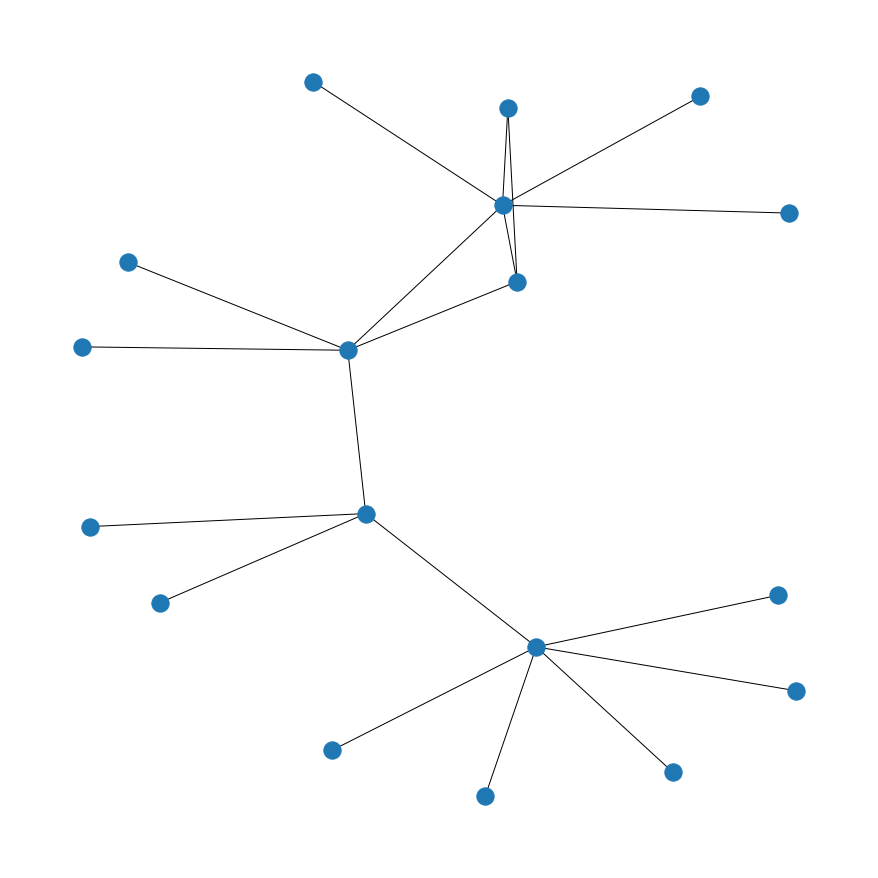

In [59]:
                  
# Plot it
plt.figure(3,figsize=(12,12)) 
nx.draw_kamada_kawai(G)

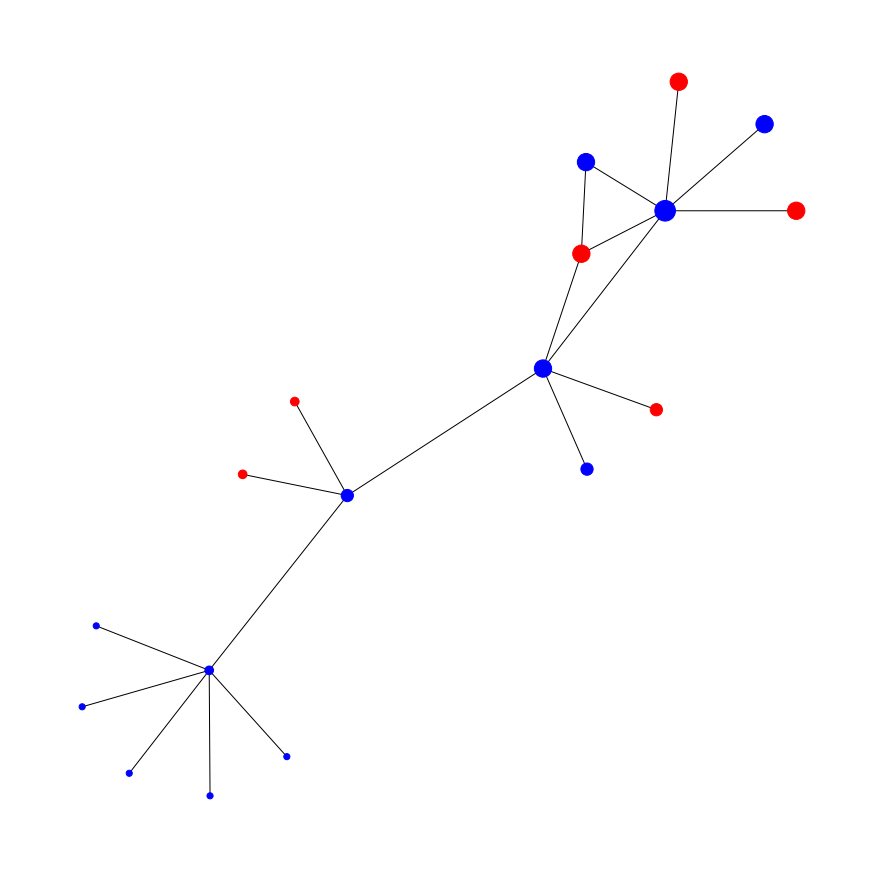

In [60]:
# larger figure size
plt.figure(3,figsize=(12,12)) 
nx.draw_spring(G, with_labels = False, node_color=colour_map, node_size=weights_map)